# Exploratory Data Analysis of ORIGA dataset

In [180]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

## Load dataset

In [181]:
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'

image_names = os.listdir(IMAGE_DIR)
mask_names = os.listdir(MASK_DIR)

images = [cv.imread(os.path.join(IMAGE_DIR, image_name)) for image_name in image_names]
images = [cv.cvtColor(image, cv.COLOR_BGR2RGB) for image in images]
masks = [cv.imread(os.path.join(MASK_DIR, mask_name), cv.IMREAD_GRAYSCALE) for mask_name in mask_names]

print(f'Number of images: {len(images)}')
print(f'Number of masks: {len(masks)}')

Number of images: 650
Number of masks: 650


## Image and Mask Properties

In [182]:
image = images[0]
mask = masks[0]

df = pd.DataFrame(columns=['Image', 'Mask'], index=['Shape', 'Dtype', 'Min', 'Max', 'Mean', 'Std'])
df['Image'] = [image.shape, image.dtype, image.min(), image.max(), image.mean(), image.std()]
df['Mask'] = [mask.shape, mask.dtype, mask.min(), mask.max(), mask.mean(), mask.std()]

print(df)

               Image        Mask
Shape  (465, 465, 3)  (465, 465)
Dtype          uint8       uint8
Min               31           0
Max              255           2
Mean      165.275466    0.941968
Std        68.877176    0.814051


## Visualize Image and Mask Pairs

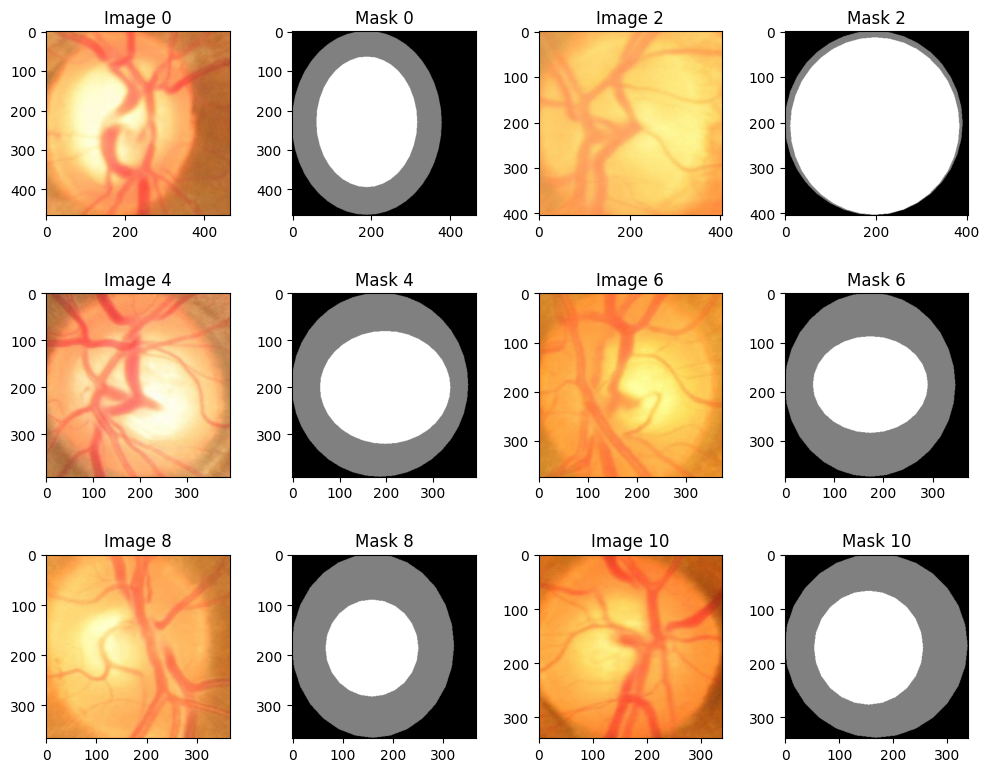

In [183]:
fig, ax = plt.subplots(3, 4, figsize=(10, 8))
ax = ax.ravel()

for i in range(0, 12, 2):
    ax[i].imshow(images[i])
    ax[i].set_title(f'Image {i}')
    ax[i + 1].imshow(masks[i], cmap='gray')
    ax[i + 1].set_title(f'Mask {i}')

plt.tight_layout()
plt.show()

## Image Resolution Analysis

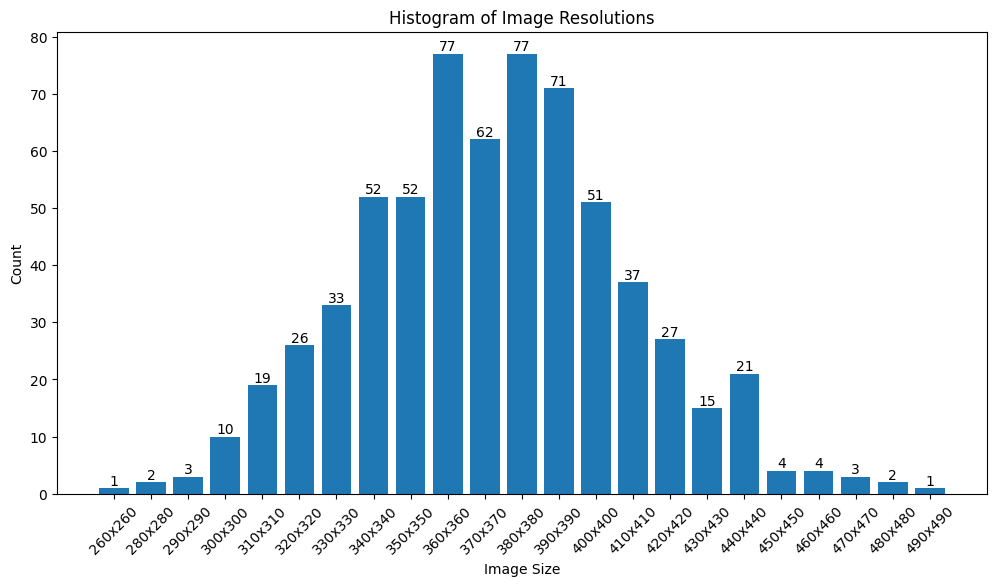

In [184]:
# Get the unique image sizes and their counts
shapes = [image.shape for image in images]
# Round shapes to nearest multiple of k
k = 10
shapes = [(round(s[0] / k) * k, round(s[1] / k) * k) for s in shapes]
# Get unique shapes and their counts
shapes, counts = np.unique(np.array(shapes), axis=0, return_counts=True)

# Plot the histogram
size_labels = [f'{s[0]}x{s[1]}' for s in shapes]
plt.figure(figsize=(12, 6))
bars = plt.bar(size_labels, counts)
plt.xlabel('Image Size')
plt.ylabel('Count')
plt.title('Histogram of Image Resolutions')
plt.xticks(rotation=45)

# Add count labels to each bar
for bar, value in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, value, ha='center', va='bottom')
plt.show()

## Class Imbalance Analysis

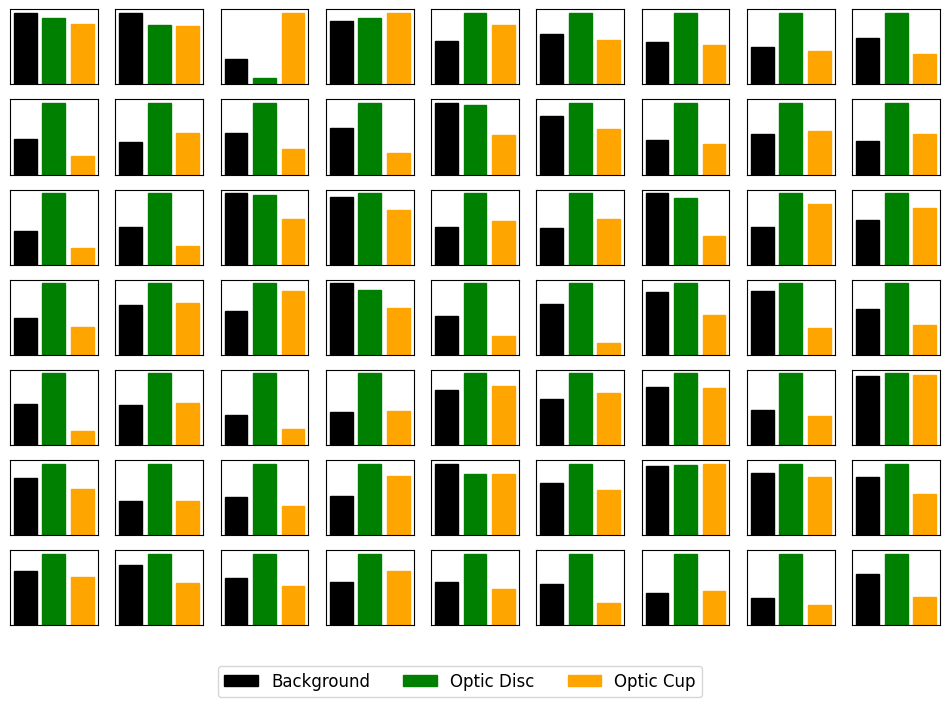

In [185]:
CLASS_NAMES = ['Background', 'Optic Disc', 'Optic Cup']
CLASS_COLORS = ['black', 'green', 'orange']

dataset_stats = {}
item_stats = np.zeros((len(masks), len(CLASS_NAMES)))

# Get the unique mask values and their counts
for i, mask in enumerate(masks):
    unique, counts = np.unique(mask, return_counts=True)
    for label, count in zip(unique, counts):
        if label not in dataset_stats:
            dataset_stats[label] = count
        else:
            dataset_stats[label] += count
    item_stats[i] = counts

# Plot class imbalance for each image in a single figure with bar subplots
fig, ax = plt.subplots(7, 9, figsize=(12, 8))
ax = ax.ravel()

for i, (axes, item_stat) in enumerate(zip(ax, item_stats)):
    bars = axes.bar(CLASS_NAMES, item_stat)
    axes.set_xticks([])
    axes.set_yticks([])
    for bar, color in zip(bars, CLASS_COLORS):
        bar.set_color(color)

fig.legend(bars, CLASS_NAMES, loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 0.01))
plt.show()

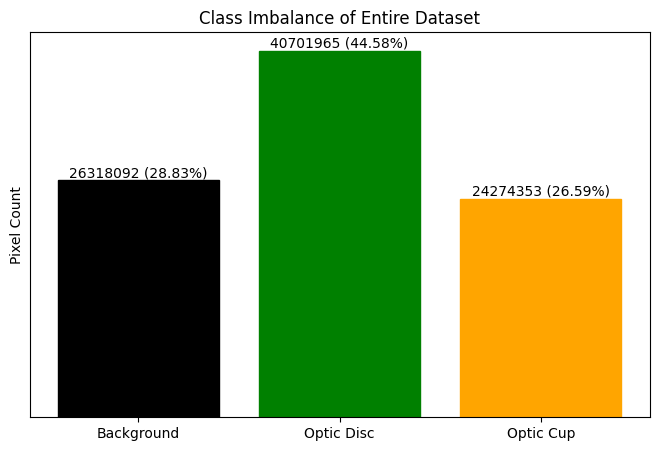

In [186]:
# Plot the histogram
plt.figure(figsize=(8, 5))
bars = plt.bar(dataset_stats.keys(), dataset_stats.values())
plt.ylabel('Pixel Count')
plt.title('Class Imbalance of Entire Dataset')
plt.xticks(list(dataset_stats.keys()), CLASS_NAMES)
plt.yticks([])

# Add count labels to each bar with percentage
total = sum(dataset_stats.values())
for bar, value in zip(bars, dataset_stats.values()):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{value} ({value / total * 100:.2f}%)',
             ha='center', va='bottom')

# Add color to each bar
for bar, color in zip(bars, CLASS_COLORS):
    bar.set_color(color)

plt.show()


## Image Channel Separation and Visualization

### RGB Channels

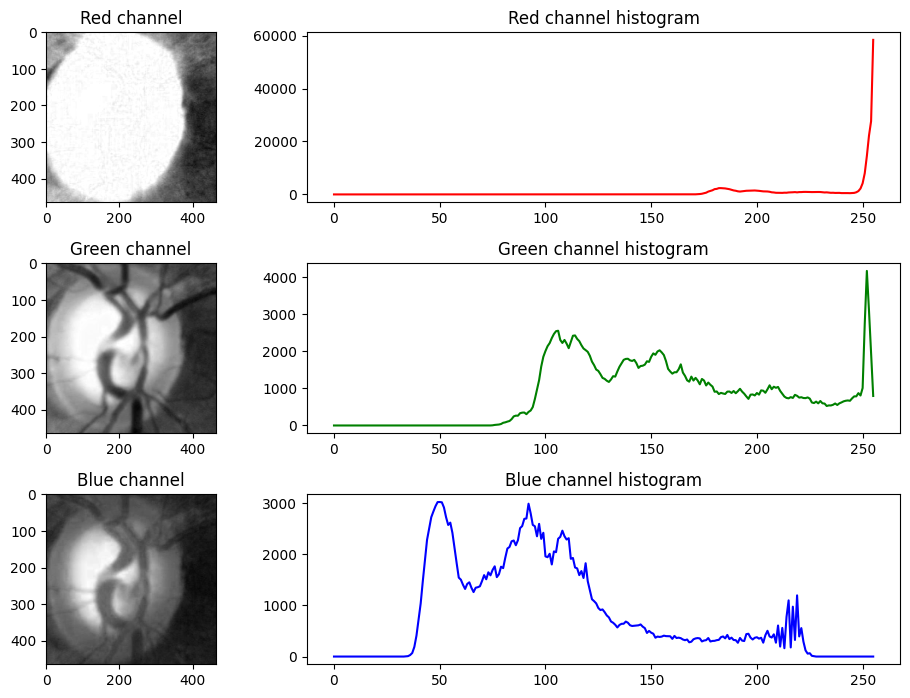

In [187]:
# Split the image into R, G, and B channels
R, G, B = cv.split(images[0])

# Calculate histogram in RGB color space
hist_r = cv.calcHist([R], [0], None, [256], [0, 256])
hist_g = cv.calcHist([G], [0], None, [256], [0, 256])
hist_b = cv.calcHist([B], [0], None, [256], [0, 256])

# Plot channels and histograms
plt.figure(figsize=(11, 8))

ax1 = plt.subplot2grid(shape=(7, 7), loc=(0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(shape=(7, 7), loc=(0, 2), colspan=4, rowspan=2)
ax3 = plt.subplot2grid(shape=(7, 7), loc=(2, 0), colspan=2, rowspan=2)
ax4 = plt.subplot2grid(shape=(7, 7), loc=(2, 2), colspan=4, rowspan=2)
ax5 = plt.subplot2grid(shape=(7, 7), loc=(4, 0), colspan=2, rowspan=2)
ax6 = plt.subplot2grid(shape=(7, 7), loc=(4, 2), colspan=4, rowspan=2)

ax1.set_title('Red channel')
ax1.imshow(R, cmap='gray')
ax2.set_title('Red channel histogram')
ax2.plot(hist_r, color='red')
ax3.set_title('Green channel')
ax3.imshow(G, cmap='gray')
ax4.set_title('Green channel histogram')
ax4.plot(hist_g, color='green')
ax5.set_title('Blue channel')
ax5.imshow(B, cmap='gray')
ax6.set_title('Blue channel histogram')
ax6.plot(hist_b, color='blue')

plt.tight_layout()
plt.show()

### Equalized RGB Channels

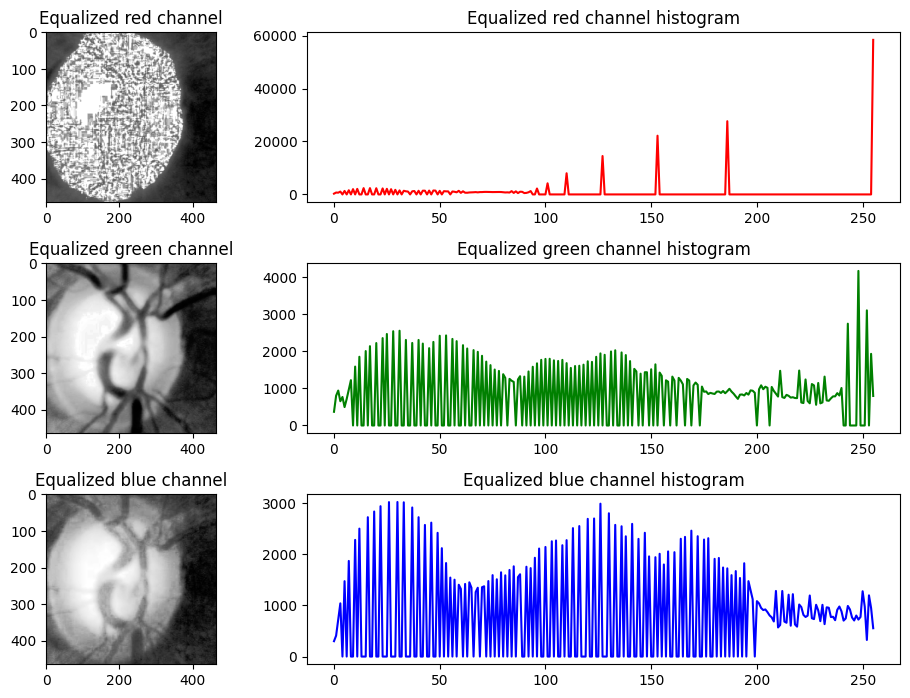

In [188]:
# Apply histogram equalization
equ_r = cv.equalizeHist(R)
equ_g = cv.equalizeHist(G)
equ_b = cv.equalizeHist(B)

# Merge the channels
equ_rgb = cv.merge((equ_r, equ_g, equ_b))

# Calculate histogram in RGB color space
equ_hist_r = cv.calcHist([equ_r], [0], None, [256], [0, 256])
equ_hist_g = cv.calcHist([equ_g], [0], None, [256], [0, 256])
equ_hist_b = cv.calcHist([equ_b], [0], None, [256], [0, 256])

# Plot channels and histograms
plt.figure(figsize=(11, 8))

ax1 = plt.subplot2grid(shape=(7, 7), loc=(0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(shape=(7, 7), loc=(0, 2), colspan=4, rowspan=2)
ax3 = plt.subplot2grid(shape=(7, 7), loc=(2, 0), colspan=2, rowspan=2)
ax4 = plt.subplot2grid(shape=(7, 7), loc=(2, 2), colspan=4, rowspan=2)
ax5 = plt.subplot2grid(shape=(7, 7), loc=(4, 0), colspan=2, rowspan=2)
ax6 = plt.subplot2grid(shape=(7, 7), loc=(4, 2), colspan=4, rowspan=2)

ax1.set_title('Equalized red channel')
ax1.imshow(equ_r, cmap='gray')
ax2.set_title('Equalized red channel histogram')
ax2.plot(equ_hist_r, color='red')
ax3.set_title('Equalized green channel')
ax3.imshow(equ_g, cmap='gray')
ax4.set_title('Equalized green channel histogram')
ax4.plot(equ_hist_g, color='green')
ax5.set_title('Equalized blue channel')
ax5.imshow(equ_b, cmap='gray')
ax6.set_title('Equalized blue channel histogram')
ax6.plot(equ_hist_b, color='blue')

plt.tight_layout()
plt.show()

### HSV Channels

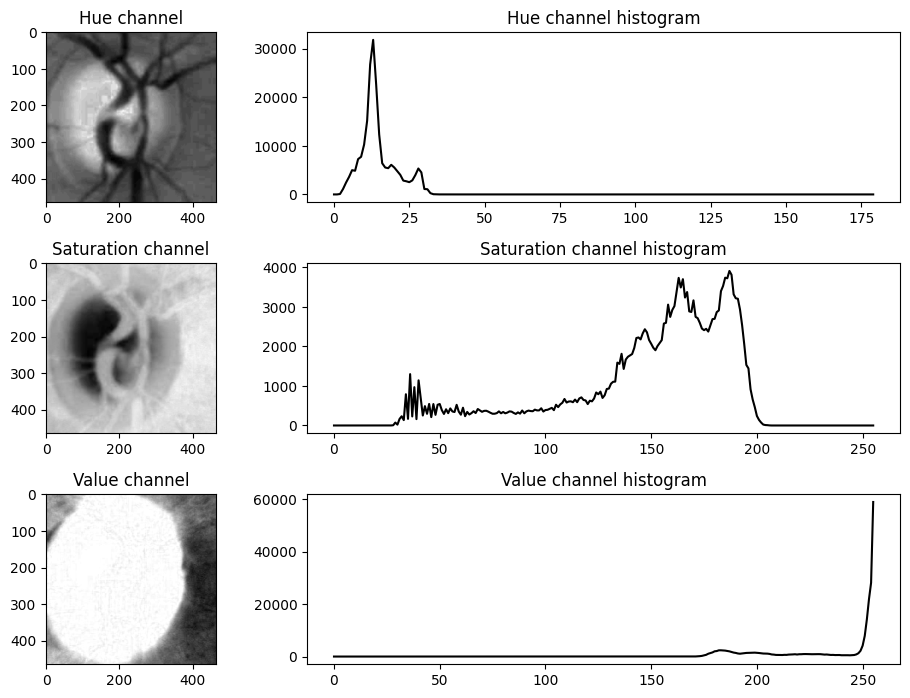

In [189]:
# Convert the image to HSV color space
hsv_img = cv.cvtColor(images[0], cv.COLOR_RGB2HSV)

# Split the image into Hue, Saturation, and Value channels
H, S, V = cv.split(hsv_img)

# Calculate histogram in HSV color space
hist_hue = cv.calcHist([H], [0], None, [180], [0, 180])
hist_sat = cv.calcHist([S], [0], None, [256], [0, 256])
hist_val = cv.calcHist([V], [0], None, [256], [0, 256])

# Plot channels and histograms
plt.figure(figsize=(11, 8))

ax1 = plt.subplot2grid(shape=(7, 7), loc=(0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(shape=(7, 7), loc=(0, 2), colspan=4, rowspan=2)
ax3 = plt.subplot2grid(shape=(7, 7), loc=(2, 0), colspan=2, rowspan=2)
ax4 = plt.subplot2grid(shape=(7, 7), loc=(2, 2), colspan=4, rowspan=2)
ax5 = plt.subplot2grid(shape=(7, 7), loc=(4, 0), colspan=2, rowspan=2)
ax6 = plt.subplot2grid(shape=(7, 7), loc=(4, 2), colspan=4, rowspan=2)

ax1.set_title('Hue channel')
ax1.imshow(H, cmap='gray')
ax2.set_title('Hue channel histogram')
ax2.plot(hist_hue, color='black')
ax3.set_title('Saturation channel')
ax3.imshow(S, cmap='gray')
ax4.set_title('Saturation channel histogram')
ax4.plot(hist_sat, color='black')
ax5.set_title('Value channel')
ax5.imshow(V, cmap='gray')
ax6.set_title('Value channel histogram')
ax6.plot(hist_val, color='black')

plt.tight_layout()
plt.show()

### Grayscale

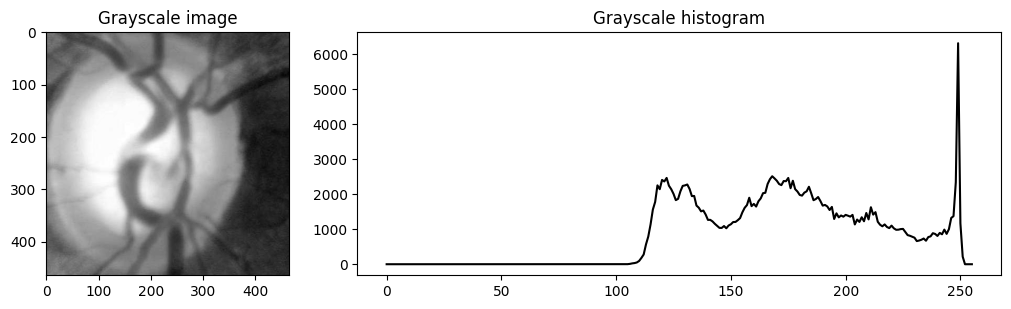

In [190]:
# Convert the image to grayscale
gray_img = cv.cvtColor(images[0], cv.COLOR_RGB2GRAY)

# Calculate histogram in grayscale
gray_hist = cv.calcHist([gray_img], [0], None, [256], [0, 256])

# Plot grayscale image and histogram
plt.figure(figsize=(12, 10))

ax1 = plt.subplot2grid(shape=(7, 7), loc=(0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid(shape=(7, 7), loc=(0, 2), colspan=4, rowspan=2)

ax1.set_title('Grayscale image')
ax1.imshow(gray_img, cmap='gray')
ax2.set_title('Grayscale histogram')
ax2.plot(gray_hist, color='black')

plt.tight_layout()
plt.show()

### CIE Lab Channels

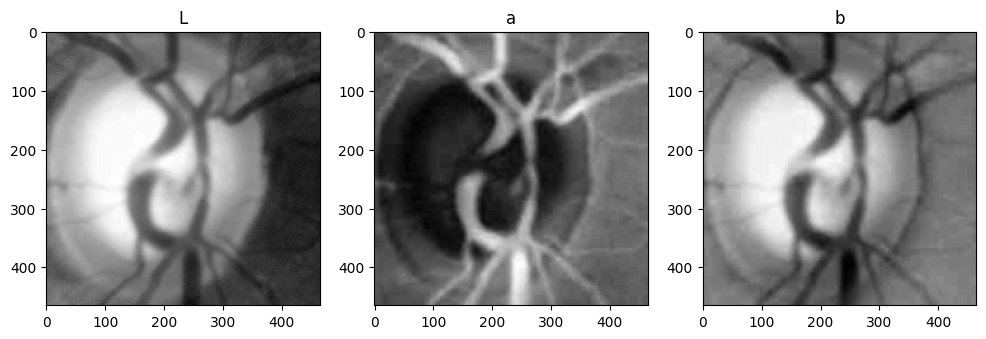

In [191]:
# Convert to 32-bit float format
float32_img = images[0].astype(np.float32) / 255.0

# Convert the image to CIE LAB color space
lab_img = cv.cvtColor(float32_img, cv.COLOR_BGR2LAB)

# Split the image into L, A, and B channels
L, A, B = cv.split(lab_img)

# Plot the channels
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title('L')
plt.imshow(L, cmap='gray')
plt.subplot(132)
plt.title('a')
plt.imshow(A, cmap='gray')
plt.subplot(133)
plt.title('b')
plt.imshow(B, cmap='gray')
plt.show()

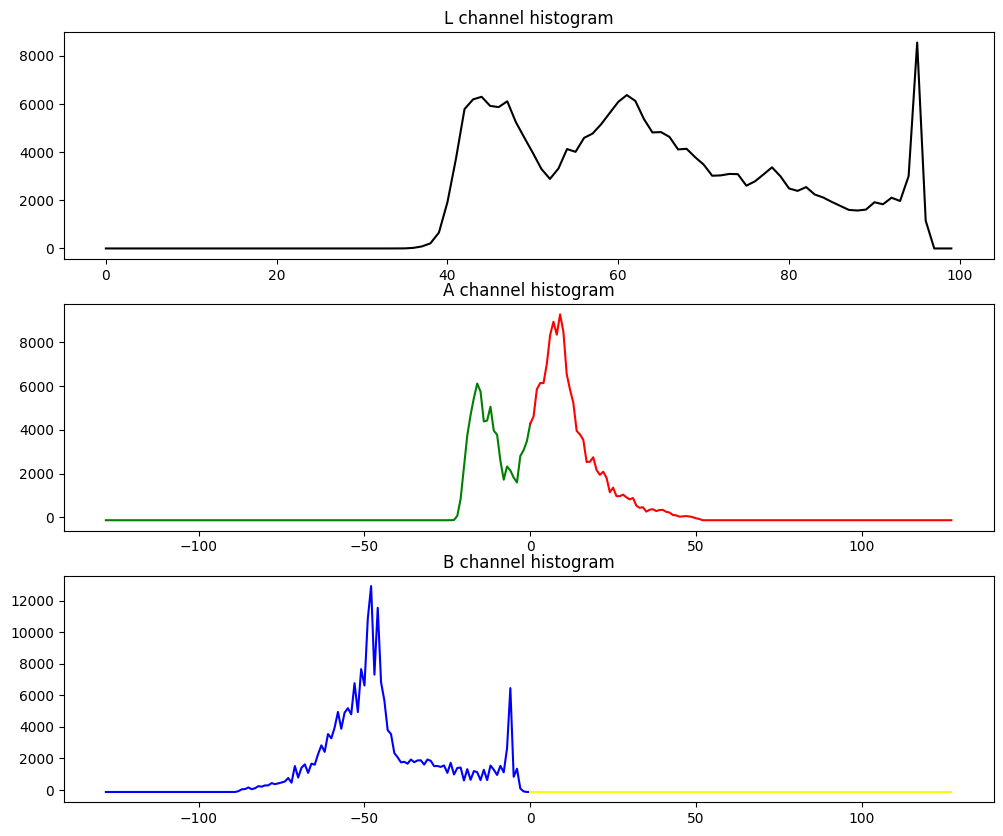

In [192]:
# Calculate histogram in LAB color space
hist_l = cv.calcHist([L], [0], None, [100], [0, 101])
hist_a = cv.calcHist([A], [0], None, [256], [-128, 128])
hist_b = cv.calcHist([B], [0], None, [256], [-128, 128])

# convert histogram to -128..128 range
hist_a = np.reshape(hist_a, (256,)) - 128
hist_b = np.reshape(hist_b, (256,)) - 128

negative_part = np.arange(-128, 1)
positive_part = np.arange(0, 128)

# Plot the histograms
plt.figure(figsize=(12, 10))
plt.subplot(311)
plt.title('L channel histogram')
plt.plot(hist_l, color='black')
plt.subplot(312)
plt.title('A channel histogram')
plt.plot(negative_part, hist_a[:129], color='green')
plt.plot(positive_part, hist_a[128:], color='red')
plt.subplot(313)
plt.title('B channel histogram')
plt.plot(negative_part, hist_b[:129], color='blue')
plt.plot(positive_part, hist_b[128:], color='yellow')
plt.show()

## Data Augmentation

Image tensor shape: torch.Size([1, 3, 256, 256])
Mask tensor shape: torch.Size([1, 256, 256])


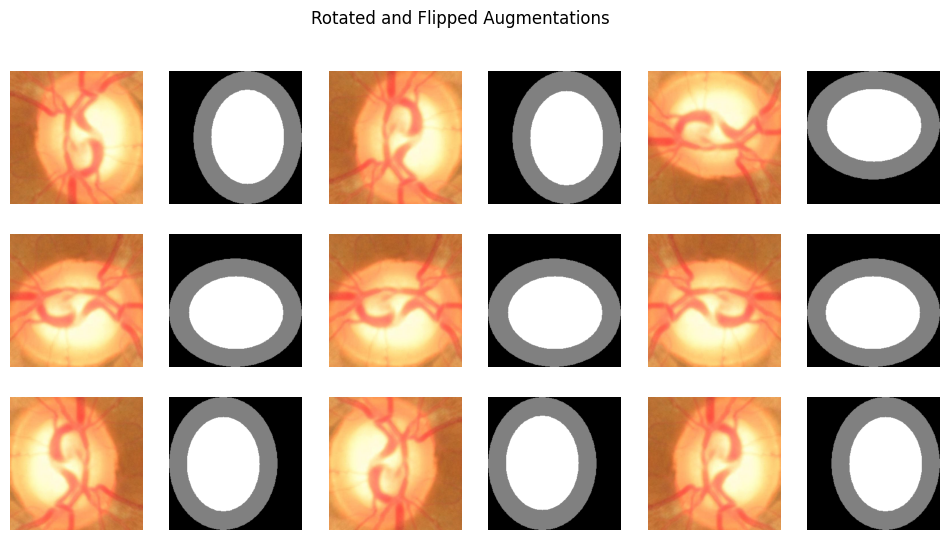

In [193]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from utils import OrigaDataset

example_ds = OrigaDataset(IMAGE_DIR, MASK_DIR, image_names[:1], A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),  # rotate by 0, 90, 180, or 270 degrees

    # A.Rotate(limit=30, p=0.33, border_mode=cv.BORDER_CONSTANT),
    # A.Lambda(image=occlude),
    # A.Lambda(image=polar_transform, mask=polar_transform),
    # A.Lambda(image=inverse_polar_transform, mask=inverse_polar_transform),
    # A.Sharpen(p=0.5, alpha=(0.1, 0.3), lightness=(0.5, 1.0)),

    # A.CLAHE(p=0.5),
    # A.RandomBrightnessContrast(p=0.5),
    # A.GridDistortion(p=0.5, border_mode=cv.BORDER_CONSTANT),
    # A.MedianBlur(p=0.5),
    # A.RandomToneCurve(p=0.5),
    # A.MultiplicativeNoise(p=0.5),

    # A.Lambda(image=keep_gray_channel),
    # A.Lambda(image=keep_red_channel),
    # A.Lambda(image=keep_green_channel),
    # A.Lambda(image=keep_blue_channel),

    ToTensorV2(),
]))

example_loader = DataLoader(example_ds, batch_size=1, shuffle=True)
example_image, example_mask = next(iter(example_loader))
print(f'Image tensor shape: {example_image.shape}')
print(f'Mask tensor shape: {example_mask.shape}')

# Plot exemplary augmented images and masks
fig, ax = plt.subplots(3, 6, figsize=(12, 6))
ax = ax.ravel()

for i in range(0, 3 * 6, 2):
    batch = next(iter(example_loader))
    batch_images, batch_masks = batch
    image, mask = batch_images[0], batch_masks[0]
    image = image.permute(1, 2, 0).numpy()
    mask = mask.numpy()
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i + 1].imshow(mask, cmap='gray')
    ax[i + 1].axis('off')

fig.suptitle('Rotated and Flipped Augmentations', fontsize=12)
plt.show()